# BACK PROPAGATION

<br>

## Introduction

<br>
Back Propagation is a <b>supervised learning algorithm used in multilayer feed-forward neural networks</b>. Back Propagation is <b>commonly employed with gradient descent optimization</b> to adjust the weight of neurons by calculating the gradient of the loss function. 

<br>
This technique is also sometimes called "backward propagation of errors", because the error is calculated at the output and distributed back through the network layers.


## Hypothesis Space

<br>
Because we are now considering networks with multiple output units (rather than single units as before), we begin by redefining our loss function to the sum of squared errors over all of the network output units : 

<br>
$
    \quad
    \begin{align}
        \operatorname{J} (w) 
        \quad &= \quad 
            \frac{1}{2n} \ \sum \ \sum _{o \ \in \ outputs} (\text{target}^{(i)}_{o} - \text{output}^{(i)}_{o})^2
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad & [\textbf{E1}]
    \end{align}
$

<br>
One major difference in the case of multilayer networks is that <b>the error surface can have multiple local minima</b>, in contrast to the single-minimum parabolic error surface shown in the notebook regarding the delta rule. Unfortunately, this means that <b>gradient descent is guaranteed only to converge toward some local minimum, and not necessarily the global minimum error</b>. 

<br>
<a id='backpropagation_cost_function_surface'>
    <img src="images/backpropagation_cost_function_surface.gif" alt="hypothesis space" width="40%" height="40%">
</a>


<br>
Despite this obstacle, back propagation has been found to produce excellent results in many real-world applications.

### Convergence

<br>
<b>Despite the lack of assured convergence to the global minimum error, Back Propagation remains a highly effective function approximation method</b> in practice. In many practical applications the problem of local minima has not been found to
be as severe as one might fear. 

<br>
To develop some intuition here, consider that networks with large numbers of weights correspond to error surfaces in very high
dimensional spaces (one dimension per weight). When gradient descent falls into a local minimum with respect to one of these weights, it will not necessarily be in a local minimum with respect to the other weights. In fact, <b>the more weights in
the network, the more dimensions that might provide "escape routes" for gradient descent to fall away from the local minimum with respect to this single weight</b>.

<br>
Gradient descent over the complex error surfaces represented by ANN is still poorly understood, and no methods are known to
predict with certainty when local minima will cause difficulties. Common heuristics to attempt to alleviate the problem of local minima include :

<br>
<ul style="list-style-type:square">
    <li>
        <b>adding momentum</b> to the <a href='#weight_update'>weight-update</a> rule; momentum can sometimes carry the gradient
        descent procedure through narrow local minima, though in principle it can also carry it through narrow global minima
        into other local minima
    </li>    
    <li>
        <b>using stochastic gradient descent</b> isntead of true gradient descent; as already discussed, the stochastic
        approximation of gradient descent effectively descends a different error surface for each training example, relying on
        the average of these examples to approximate the gradient with respect to the full training set. These <b>different
        error surfaces will typically have different local minima</b>, making it less likely that the process will get stuck in
        any one of them
    </li>    
    <li>
        <b>training multiple networks</b> using the same data, but <b>with different initialization weights</b>; if the
        different training efforts lead to different local minima, then the network with the best performance over a separate
        validation data set can be selected. Alternatively, all networks can be retained and treated as a "committee" of
        networks whose output is the (possibly weighted) average of the individual network outputs
    </li>
</ul>

## The Algorithm

<br>
The back propagation algorithm as described here applies to feedforward networks containing a total of three layers of differentiable activation functions (two hidden layersand the output layer), with units at each layer connected to all units from the preceding layer. 

<br>
Let's begin with a notation which lets us refer to the componentes of the network in an unambiguous way :

<br>
<ul style="list-style-type:square">
    <li>
        $ w_{jk}^{\ (l)} $ denotes to the weight assigned to the connection from the $ k^{\rm th} $ neuron in the 
        $ (l-1)^{\rm th} $ layer to the $ j^{\rm th} $ neuron in the $ l^{\rm th} $ layer; <br>
        the vector $ w^{\ (l)} $ represents the weights assigned to the totality of the connections to the $ l^{\rm th} $ layer
    </li>    
    <li>
        $ b_{j}^{\ (l)} $ denotes the bias added to the $ j^{\rm th} $ neuron in the $ l^{\rm th} $ layer; this term can be
        decomposed into its own weight and (constant) input components, and is usually expressed as part of the dot product
        ( $ \Sigma_{\ k = 0} w_{jk}^{\ (l)} $ instead of $ \Sigma_{\ k = 1} w_{jk}^{\ (l)} + b_{j}^{\ (l)}$ ); the vector 
        $ b^{\ (l)}$ represents the weights assigned to the bias vector for the $ l^{\rm th} $ layer
    </li>    
    <li>
        $ z_{j}^{\ (l)} $ denotes the net input for the $ j^{\rm th} $ neuron in the $ l^{\rm th} $ layer; 
        the vector $ z^{\ (l)}$ represents the net inputs associated to each neuron in the $ l^{\rm th} $ layer
    </li>
    <br>
    <li>
        $ a_{j}^{\ (l)} $ denotes the value returned when the net input $ z_{j}^{\ (l)} $ is passed through the activation
        function ($ \operatorname{g} $ in this notebook); the vector $ a^{\ (l)} $ represents the activations values of the 
        $ l^{\rm th} $ layer, which will serve as the input vector for the next layer
    </li>
    <br>
    <li>
        $ \delta_n $ denotes the error term associated with unit $n$; this term plays a role analogous to the quantity $ (t - o)
        $ we used in our earlier discussion of the delta training rule; as we will see later in this notebook, 
        $ \delta_n = \frac{\partial \ \operatorname{J}}{\partial \ net_n} $ 
    </li>
</ul>

<br>
The learning algorithm can be divided into three phases : <b>initialization, forward propagation, and back-propagation</b>.


In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.datasets import load_boston
import sklearn.neural_network as nn

import utilcompute as uc
import preprocessing as pre
import artificial_neural_networks as ann


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_boston().data, load_boston().target) )
df = pd.DataFrame(data)
df.columns = [
    'CRIM',    # per capita crime rate by town
    'ZN',      # proportion of residential land zoned for lots over 25,000 sq.ft.
    'INDUS',   # proportion of non-retail business acres per town
    'CHAS',    # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    'NOX',     # nitric oxides concentration (parts per 10 million)
    'RM',      # average number of rooms per dwelling
    'AGE',     # proportion of owner-occupied units built prior to 1940
    'DIS',     # weighted distances to five Boston employment centres
    'RAD',     # index of accessibility to radial highways
    'TAX',     # full-value property-tax rate per $10,000
    'PTRATIO', # pupil-teacher ratio by town
    'B',       # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    'LSTAT',   # % lower status of the population
    'MEDV'     # median value of owner-occupied homes in $1000's
]


In [3]:
target = 'MEDV'
features = [c for c in df.columns if (c != target)]


In [4]:
# DATA PREPROCESSING (TRAIN + VALIDATION) : features transformation

excluded_features = ['CHAS']
included_features = [f for f in features if (f not in excluded_features)]

df_std = pre.standardize(df = df, included = included_features, excluded = uc.concatenate(excluded_features,target))


The weights are still random but differ in range depending on the size of the previous layer of neurons. This provides a controlled initialisation hence the faster and more efficient gradient descent.

Assigning the network weights before training sometimes can be treated as a random process, since we do not know anything about the data, so we are not sure how to assign the weights that would work in that particular case.

### Phase I : Initialization

<br>
There are a number of important choices that need to be made when building and training a neural network : which loss function to use, which activation function, how many layers to have, which optimization algorithm is best suited for the network, etc. With so many things that need to be decided, the choice of initial weights may, at first glance, seem like just another relatively minor detail, but we will see that weight initialization can actually have a profound impact on both the convergence rate and final quality of a network.

<br>
<b>All-Zero</b> 

<br>
We do not know what the final value of every weight should be in the trained network, but with proper data normalization it is reasonable to assume that approximately half of the weights will be positive and the other half will be negative.

<br>
A plausible idea then might be to set all the initial weights to zero, which we expect to be the "best guess". This would turn out to be a mistake, because <b>if every neuron in the network computes the same output, then they will also all compute the same gradients during back-propagation and undergo the exact same parameter updates</b>. In other words, there is <b>no source of asymmetry</b> among neurons if the weights are initialized to the same value.

<br><br>
<b>Small Random Numbers</b> 

<br>
We still want the weights to be very close to zero but, as we have argued above, not identically zero. A common solution is to initialize the weights to small random numbers; the idea is that <b>neurons, when given different initial weight vectors, will compute distinct updates and integrate themselves as diverse parts of the full network</b>. 

<br>
<b>Each weight vector is initialized as a random vector sampled from a multi-dimensional gaussian with zero mean and unit standard deviation</b>. It is also possible to use small numbers drawn from a uniform distribution, but this seems to have relatively little impact on the final performance in practice.

<br>
Warning: it’s not necessarily the case that smaller numbers will work strictly better. Since gradients are proportional to the value of the associated weights, a layer with very small weights will yield (during back propagation) very small gradients; this could greatly diminish the "gradient signal" flowing backward through the network, and could become a concern for deep networks.

<br><br>
<b>Calibrating the Variance</b> 

<br>
One problem with the suggestion above is that <b>the distribution of the outputs from a randomly initialized neuron has a variance that might vanish (or explode) with the number of inputs</b> :

<br>
<ul style="list-style-type:square">
    <li>
        if the weights start too small, then the signal shrinks as it passes through each layer until it’s too tiny to be useful
    </li>
    <br>
    <li>
        if the weights start too large, then the signal grows as it passes through each layer until it’s too massive to be
        useful
    </li>
</ul>

<br>
In order to avoid the two extreme situation highlighted above, our aim should be to maintain the variance of the activation values throughout the network; shortly, we will see how <b>normalizing the output of each neuron to a suitable variance makes sure the weights are "just right", keeping the signal in a reasonable range of values through many layers</b>. The key concept of variance calibration is to automatically determine the scale of the weights initialization matrix based on the number of input and output neuron at each layer.

<br>
Consider the inner product $ s = \sum_i^n w_i x_i $ between the weights and the input vector, which gives the net input of a neuron before the activation function. Let's examine the variance of this term :

<br>
$
    \quad
    \begin{align}
        \mathrm{Var}(s) 
        &= 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad & \text{by definition}
        \newline
        &= \mathrm{Var} \ \bigg( \ \sum_i^{n_{\ in}} w_i \cdot x_i \ \bigg)
        \newline
        &= \sum_i^{n_{\ in}} \mathrm{Var} \ (w_i \cdot x_i)
        \newline
        &= \sum_i^{n_{\ in}} {
              \operatorname{E}[w_i]^2 \ \mathrm{Var} \ (x_i) 
            + \operatorname{E}[x_i]^2 \ \mathrm{Var} \ (w_i) 
            + \mathrm{Var} \ (x_i) \ \mathrm{Var} \ (w_i)
            }
            & \text{assuming } \operatorname{E} \ [x_i] = \operatorname{E} \ [w_i] = 0
        \newline
        &= 
            \sum_i^{n_{\ in}} { \mathrm{Var} \ (x_i) \ \mathrm{Var} \ (w_i) }
            & \text{assuming } w_i, x_i \text{ are IID}
        \newline
        &= 
            n_{in} \ \mathrm{Var} \ (w) \ \mathrm{Var} \ (x)
            & [\textbf{E2}] 
    \end{align}
$

<br>
It is easy to see that the variance of the neuron output is a scaled version of the variance of the input; if we want the two quantities to be the same (or, in other words, if we want the keep the signal in a range of values consistent across layers) we have to impose the following condition on the initial weights :

<br>
$
    \quad
    \begin{align*}
        &
        \begin{aligned}[t]
            \mathrm{Var} \ (w) & = 1 \ / \ n_{in}
        \end{aligned}        
        \newline \newline
        \quad \Rightarrow \quad
        & 
            w \sim \mathcal{N} \ \big( \ 0 \ , \ \sqrt{ 1 \ / \ n_{in} } \ \big)
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E3}] 
    \end{align*}
$

<br>
<b>Scaling the standard deviation of the initial weight vector by the square root of the neuron fan-in</b> (the number of inputs) ensures that at the beginning all neurons in the network have approximately the same output distribution; best known as <b>Xavier Initialization</b>, this normalization technique has been proven to improve the rate of convergence.

<br>
A similar analysis is carried out in <a href="http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf">Understanding the difficulty of training deep feedforward neural networks</a> (<b>Glorot and Bengio</b>) : in this paper, the authors explain that :

<br>
<ul style="list-style-type:square">
    <li>
        from a forward-propagation point of view, to keep information flowing we would like to have <br>
        $ \mathrm{Var} \ (w) \quad = \quad 1 \ / \ n_{in} $
    </li>
    <br>
    <li>
        from a back-propagation point of view, to keep the variance of the input and output gradient consistent across layers,
        we would like to have <br>
        $ \mathrm{Var} \ (w) \quad = \quad 1 \ / \ n_{out} $
    </li>
</ul>

<br>
These two constraints can only be satisfied simultaneously if $ n_{in} = n_{out} $. Unless this is actually the case, we should aim to a reasonable compromise of the two conditions. <b>Glorot and Bengio</b> recommend an initialization in the form of the <b>harmonic mean</b> :

<br>
$
    \quad
    \begin{align*}
        &
        \begin{aligned}[t]
            \mathrm{Var}(w) \quad = \quad 2 \ / \ (n_{in} + n_{out})
        \end{aligned}        
        \newline \newline
        \quad \Rightarrow \quad
        & 
            w \sim \mathcal{N} \ \big( \ 0 \ , \ \sqrt{ 2 \ / \ (n_{in} + n_{out}) } \ \big)
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad  
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad & [\textbf{E4}] 
    \end{align*}
$

where $ n_{in} $ and $ n_{out} $ are, respectively, the number of units in the previous and next layer. 

<br>
Glorot initialization works pretty well with sigmoidal non-linearities, but the network have difficulties to converge in case of ReLU. A more recent paper on this topic, <a href="http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf">Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification</a> (<b>He</b> et al., 2015), <b>derives an initialization specifically for ReLU neurons, which is the current recommendation for use in the specific case</b> of neural networks with ReLU neurons :

<br>
$
    \quad
    \begin{align*}
        &
        \begin{aligned}[t]
            \mathrm{Var}(w) \quad = \quad 2 \ / \ n_{in}
        \end{aligned}        
        \newline \newline
        \quad \Rightarrow \quad
        & 
            w \sim \mathcal{N} \ \big( \ 0 \ , \ \sqrt{ 2 \ / \ n_{in} } \ \big)
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E5}] 
    \end{align*}
$

<br><br>
<b>Sparse Initialization</b> 

<br>
Another way to address the problem of uncalibrated variances is to set all weight matrices to zero but, in order to break symmetry, every neuron is randomly connected (with weights sampled from a small gaussian as above) to a fixed number of neurons below it. A typical number of neurons to connect to may be as small as 10.

<br><br>
<b>Initializing Biases</b> 

<br>
It is possible (and common) to initialize the biases to zero, since the asymmetry is provided by the small random numbers in the weights. Setting all biases to a small constant value such as 0.01 ensures that all ReLU units fire in the beginning and therefore obtain and propagate some gradient. However, it is not clear if this provides a consistent improvement (in fact some results seem to indicate that this performs worse) and it is more common to simply use zero bias initialization.


In [5]:
hidden_layers = [100,100]

weights = []
for l in range(0, len(hidden_layers)):    
    layer_weight_vector = np.zeros(shape = (hidden_layers[l],1), dtype = float)
    weights.append(layer_weight_vector)
weights_all_zero = weights

weights = []
np.random.seed(1)
for l in range(1, len(hidden_layers)):    
    layer_weight_vector = np.random.randn(hidden_layers[l], hidden_layers[l-1])
    weights.append(layer_weight_vector)
weights_small_random_number = weights

weights = []
np.random.seed(1)
for l in range(1, len(hidden_layers)):    
    factor = np.sqrt(1.0 / hidden_layers[l-1])
    layer_weight_vector = np.random.randn(hidden_layers[l], hidden_layers[l-1]) * factor
    weights.append(layer_weight_vector)
weights_xavier = weights

weights = []
np.random.seed(1)
for l in range(1, len(hidden_layers)):    
    factor = np.sqrt(2.0 / hidden_layers[l-1])
    layer_weight_vector = np.random.randn(hidden_layers[l], hidden_layers[l-1]) * factor
    weights.append(layer_weight_vector)
weights_he = weights

weights = []
np.random.seed(1)
for l in range(1, len(hidden_layers)):  
    factor = np.sqrt(2.0 / (hidden_layers[l] + hidden_layers[l-1]))
    layer_weight_vector = np.random.randn(hidden_layers[l], hidden_layers[l-1]) * factor
    weights.append(layer_weight_vector)
weights_glorot = weights


In [6]:
max_iter = 50

mlp_list = [
    { 'df' : df_std, 'module' : nn, 'model_name' : 'MLPRegressor', 
     'model_args' : { 'hidden_layer_sizes' : (100,100), 'activation' : 'relu', 'solver' : 'sgd', 
                     'learning_rate' : 'adaptive', 'learning_rate_init' : 0.001, 'max_iter' : max_iter}, 
     'weights' : weights_all_zero, 
     'note' : 'all-zero' 
    },
    { 'df' : df_std, 'module' : nn, 'model_name' : 'MLPRegressor', 
     'model_args' : { 'hidden_layer_sizes' : (100,100), 'activation' : 'relu', 'solver' : 'sgd', 
                     'learning_rate' : 'adaptive', 'learning_rate_init' : 0.001, 'max_iter' : max_iter}, 
     'weights' : weights_small_random_number, 
     'note' : 'small random numbers' 
    },
    { 'df' : df_std, 'module' : nn, 'model_name' : 'MLPRegressor', 
     'model_args' : { 'hidden_layer_sizes' : (100,100), 'activation' : 'relu', 'solver' : 'sgd', 
                     'learning_rate' : 'adaptive', 'learning_rate_init' : 0.001, 'max_iter' : max_iter}, 
     'weights' : weights_xavier, 
     'note' : 'xavier variance calibration' 
    },
    { 'df' : df_std, 'module' : nn, 'model_name' : 'MLPRegressor', 
     'model_args' : { 'hidden_layer_sizes' : (100,100), 'activation' : 'relu', 'solver' : 'sgd', 
                     'learning_rate' : 'adaptive', 'learning_rate_init' : 0.001, 'max_iter' : max_iter}, 
     'weights' : weights_he, 
     'note' : 'he variance calibration' 
    },
    { 'df' : df_std, 'module' : nn, 'model_name' : 'MLPRegressor', 
     'model_args' : { 'hidden_layer_sizes' : (100,100), 'activation' : 'relu', 'solver' : 'sgd', 
                     'learning_rate' : 'adaptive', 'learning_rate_init' : 0.001, 'max_iter' : max_iter}, 
     'weights' : weights_glorot, 
     'note' : 'glorot variance calibration' 
    } 
]

results = pd.DataFrame()

for l in mlp_list:
    results_temp = ann.compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        module = l['module'],
        model_name = l['model_name'], 
        model_args = l['model_args'],
        weights = l['weights'],
        note = l['note'],
        task = 'regression',
        debug = False
    )
    results = results.append(results_temp).reset_index(drop = True)
    

C:\Users\danis_p50\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


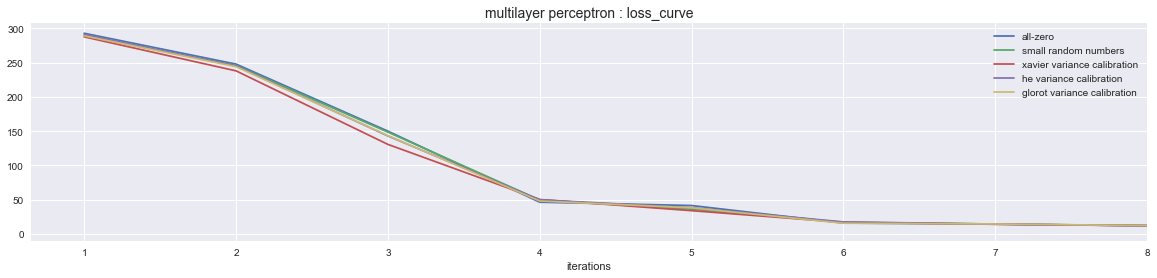

In [7]:
iterations = np.arange(1, max_iter + 1)

scoring_list = {'loss_curve' : 'neg_loss_curve'}
    #'MSE' : 'neg_mean_squared_error', 
    #'R2' : 'r2'}

ann.plot_scoring_list(
    x = iterations, 
    scoring_list = scoring_list,
    discriminant_col = 'note',
    results_df = results, 
    plot_args = {
        'xticks' : iterations, 'xscale' : 'linear', 'xlim' : (0.65,8), 'xlabel' : 'iterations', 
        'title' : 'multilayer perceptron', }
)

### Phase II : Forward Propagation

<br>
The architecture depicted in the figure below is a Multi-Layer Perceptron; MLP can be understood as a network of multiple artificial neurons over multiple layers, connected by means of non-linear activation functions which allow the network to create complex, non-linear decision boundaries and tackle a variety of linear and non-linear problems. The first hidden layer will be able to learn very simple patterns, and each additional hidden layer will be able to learn progressively more complicated patterns. 

<br>
When calculating the depth of a deep neural network, we only consider the layers that have weights attached to them; in other words, we usually count the number of hidden layers along with the output layer. The ann in the picture is therefore a three-layers (deep) neural network. 

<br>
<b>Note</b> : the term "perceptron" is a little bit unfortunate in this context, since it really doesn’t have much to do with Rosenblatt’s Perceptron algorithm. 


<br>
<a id='forward_propagation'>
    <img src="images/multi_layer_perceptron.png" alt="forward propagation" width="70%" height="70%">
</a>

<br>
<b>A neural network generates an output after passing all the inputs across the layers.</b> This process is called <b>forward propagation</b>, and can be summarized in the following steps :

<ol>
    <li>for each neuron in the first hidden layer :
        <br>
        <ol type="a">
            <li>compute the dot product $ z $ of the weights and input vectors (including bias)</li>
            <li>
                feed $ z $ into the neuron activation function, the activation values $ a $ will provide the input for the next
                hidden layer
            </li>
        </ol>
        <br><br>
        $
            \quad
            \begin{bmatrix}
                \ a_{1}^{\ (1)}  \ \\
                \ a_{2}^{\ (1)}  \ \\
                \ \vdots \ \\
                \ a_{4}^{\ (1)} \
            \end{bmatrix}_\textit{ 4 x 1}
            \quad = \quad
            \begin{bmatrix}
                \ \operatorname{g} \ ( \ z_{1}^{\ (1)} \ ) \ \\
                \ \operatorname{g} \ ( \ z_{2}^{\ (1)} \ ) \ \\
                \ \vdots \ \\
                \ \operatorname{g} \ ( \ z_{4}^{\ (1)} \ ) \ 
            \end{bmatrix}_\textit{ 4 x 1}
            \quad = \quad
            \operatorname{g} \ 
            \begin{bmatrix}
                \  
                      W_{10}^{\ (1)} \cdot x_{0} 
                    + W_{11}^{\ (1)} \cdot x_{1} 
                    + W_{12}^{\ (1)} \cdot x_{2} 
                    + W_{13}^{\ (1)} \cdot x_{3} \ 
                \
                \\
                \ 
                      W_{20}^{\ (1)} \cdot x_{0} 
                    + W_{21}^{\ (1)} \cdot x_{1} 
                    + W_{22}^{\ (1)} \cdot x_{2} 
                    + W_{23}^{\ (1)} \cdot x_{3} \ 
                \
                \\
                \ \vdots \
                \\ 
                \ 
                      W_{40}^{\ (1)} \cdot x_{0} 
                    + W_{41}^{\ (1)} \cdot x_{1} 
                    + W_{42}^{\ (1)} \cdot x_{2} 
                    + W_{43}^{\ (1)} \cdot x_{3}
                \
            \end{bmatrix}_\textit{ 4 x 1}
        $        
    <br><br>
    <li>repeat the above steps for all layers, further propagating the signal towards the output layer</li>
    <br><br>
    $
        \quad
        \begin{bmatrix}
            \ a_{1}^{\ (2)}  \ \\
            \ a_{2}^{\ (2)}  \ \\
            \ \vdots \ \\
            \ a_{4}^{\ (2)} \
        \end{bmatrix}_\textit{ 4 x 1}
        \quad = \quad
        \begin{bmatrix}
            \ \operatorname{g} \ ( \ z_{1}^{\ (2)} \ ) \ \\
            \ \operatorname{g} \ ( \ z_{2}^{\ (2)} \ ) \ \\
            \ \vdots \ \\
            \ \operatorname{g} \ ( \ z_{4}^{\ (2)} \ ) \ 
        \end{bmatrix}_\textit{ 4 x 1}
        \quad = \quad
        \operatorname{g} \ 
        \begin{bmatrix}
            \ 
                  W_{10}^{\ (2)} \cdot a_{0}^{\ (1)} 
                + W_{11}^{\ (2)} \cdot a_{1}^{\ (1)} 
                + \ \cdots \
                + W_{14}^{\ (2)} \cdot a_{4}^{\ (1)} \ 
            \
            \\
            \ 
                  W_{20}^{\ (3)} \cdot a_{0}^{\ (1)} 
                + W_{21}^{\ (3)} \cdot a_{1}^{\ (1)} 
                + \ \cdots \
                + W_{24}^{\ (3)} \cdot a_{4}^{\ (1)} \ 
            \
            \\
            \ \vdots \
            \\
            \ 
                  W_{40}^{\ (3)} \cdot a_{0}^{\ (1)} 
                + W_{41}^{\ (3)} \cdot a_{1}^{\ (1)} 
                + \ \cdots \
                + W_{44}^{\ (3)} \cdot a_{4}^{\ (1)} \ 
            \
        \end{bmatrix}_\textit{ 4 x 1}
    $
    <br><br>
    <li>collect the output</li>
    <br><br>
    $
        \quad
        \begin{bmatrix}
            \ o_{1} \ \\
            \ o_{2} \ 
        \end{bmatrix}_\textit{ 2 x 1}
        \quad = \quad
        \begin{bmatrix}
            \ \operatorname{g} \ ( \ z_{1}^{\ (3)} \ ) \ \\
            \ \operatorname{g} \ ( \ z_{2}^{\ (3)} \ ) \ \\
        \end{bmatrix}_\textit{ 2 x 1}
        \quad = \quad
        \operatorname{g} \
        \begin{bmatrix}
            \ 
                  W_{10}^{\ (3)} \cdot a_{0}^{\ (2)} 
                + W_{11}^{\ (3)} \cdot a_{1}^{\ (2)} 
                + \ \cdots \
                + W_{14}^{\ (3)} \cdot a_{4}^{\ (2)} \ 
            \
            \\
            \ 
                  W_{20}^{\ (3)} \cdot a_{0}^{\ (2)} 
                + W_{21}^{\ (3)} \cdot a_{1}^{\ (2)} 
                + \ \cdots \
                + W_{24}^{\ (3)} \cdot a_{4}^{\ (2)} 
            \         
        \end{bmatrix}_\textit{ 2 x 1}
    $
</ol>


### Phase III : Back Propagation

<br>
When we started this notebook, we said that <b>Back Propagation a supervised learning algorithm <i>commonly employed with gradient descent</i> to adjust the weights matrix of an artificial neural network</b>, but what does that mean exactly? Which algorithm is responsible for what ? 

<br>
We discussed gradient descent when we first introduced it in the notebook about the delta rule; we know it's a general, iterative optimization algorithm that can be used to search through a large (or infinite) hypothesis space as long as two conditions are met :

<br>
<ul style="list-style-type:square">
    <li>
        the hypothesis space itself contains continuously parameterized hypotheses (e.g. the weights in a linear unit)
    </li>
    <br>
    <li>
        the error can be differentiated with respect to these hypothesis parameters
    </li>
</ul>

<br><br>
Let's take a look at the cost function and we may start to see the issue in applying gradient descent on deep neural networks : <b>there is no direct relationship between the cost function $ \operatorname{J} (w) $ and the weights $ (w) $ </b>.

<br>
$
    \quad
    \begin{align}
        \operatorname{J} (w) 
        &= 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad  & \text{by } \textbf{E1}
        \newline
        &= \frac{1}{2n} \ \sum \ \sum _{o \ \in \ outputs} (\text{target}^{(i)}_{o} - \text{output}^{(i)}_{o})^2
        \newline
        &= \frac{1}{2n} \ \sum \ \bigg[ \ (y_{1}^{ \ (i)} - o_{1}^{ \ (i)})^2 +  (y_{2}^{ \ (i)} - o_{2}^{ \ (i)})^2 \ \bigg]
    \end{align}
$


<br>
Recall that <b>by using gradient descent we need to find the gradient of our cost function with respect to (w.r.t.) the weights</b>; in order to find this gradient, we need to compute the partial derivative of the cost with all the variables in the preceding layers, such as the activation values $ a $ and the net inputs $ z $. This is where we need Back Propagation. 

<br>
$
    \quad
    \begin{align}
        { \frac {\partial \ J}             {\partial \ W_{14}^{\ (3)}} }
        \quad &= \quad 
        { \frac {\partial \ J}             {\partial \ a_{1}^{\ (3)}}  } \ \cdot \
        { \frac {\partial \ a_{1}^{\ (3)}} {\partial \ z_{1}^{\ (3)}}  } \ \cdot \ 
        { \frac {\partial \ z_{1}^{\ (3)}} {\partial \ W_{14}^{\ (3)}} }
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad  
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E6}] 
    \end{align}
$

<br>
<b>Back Propagation is basically a repeated application of chain rule of calculus for partial derivatives, and provides probably the most efficient technique to find the gradient of our cost function w.r.t. all the learnable parameters in the neural network</b>.

<br>
<b>Derivative of the error with respect to the activation value</b>

<br>
$
    \quad
    \begin{align}
        \frac {\partial \ J} {\partial \ a_{1}^{\ (3)}}
        \quad &= \quad 
        \frac {\partial}{\partial \ o_{1} } \ \bigg[ \frac{1}{2n} \ (y_{1} - o_{1})^2 \bigg]
        \quad = \quad 
        - \ (y_{1} - o_{1})
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E6-A}] 
    \end{align}
$


<br>
<b>Derivative of the activation value with respect to the net input</b>

<br>
$
    \quad
    \begin{align}
        \frac {\partial \ a_{1}^{\ (3)}} {\partial \ z_{1}^{\ (3)}} 
        \quad &= \quad 
        \newline 
        \quad &= \quad 
            \frac 
                {\partial}
                {\partial \ z_{1}^{\ (3)}} \ \bigg[ \ \frac{1}{1 + e^{ \ - \left( \ z_{1}^{\ (3)} \ \right)}} \ \bigg]
        \newline \newline
        \quad &= \quad 
            \frac 
                { e^{- \left( \ z_{1}^{\ (3)} \ \right)} } 
                { \left( \ 1 + e^{ \ - \left( \ z_{1}^{\ (3)} \ \right)} \ \right)^2 }
        \newline \newline
        \quad &= \quad 
               \left[ \ 1 - \frac{1}{ 1 + e^{ \ - \left( \ z_{1}^{\ (3)} \ \right)} } \ \right]
             \ \frac{1}{ 1 + e^{ \ - \left( \ z_{1}^{\ (3)} \ \right)} }
        \newline \newline
        \quad &= \quad
            ( \ 1 - a_{1}^{\ (3)} \ ) \ a_{1}^{\ (3)}
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E6-B}] 
    \end{align}
$


<br>
<b>Derivative of the net input with respect to a weight</b>

<br>
Please note that the only one term of the net input that will have a non-zero derivative is the one associated with the particular weight we are considering : 

<br>
$
    \quad
    \begin{align}
        \frac {\partial \ z_{1}^{\ (3)}} {\partial \ W_{14}^{\ (3)}} 
        \quad &= \quad 
        \newline 
        \quad &= \quad 
            \frac {\partial}{\partial \ W_{14}^{\ (3)}} 
            \ \bigg[ \ 
                  W_{10}^{\ (3)} \cdot a_{0}^{\ (2)} 
                + W_{11}^{\ (3)} \cdot a_{1}^{\ (2)} 
                + \ \cdots \
                + W_{14}^{\ (3)} \cdot a_{4}^{\ (2)} 
            \ \bigg]
        \newline \newline
        \quad &= \quad 
            a_{4}^{\ (2)}
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E6-C}] 
    \end{align}
$


<br>
<b><a id='weight_update'>Weight Update</a></b>

<br>
Now that we have back-propagated the error term throughout the network and calculated the partial derivative of the cost function w.r.t. every single component (activation values, net inputs, and weights), we can lay out our findings into an explicit change rule, just like we did for the perceptron and delta rules :

<br>
$
    \quad
    \begin{align}
        \Delta W_{14}^{\ (3)} 
        &= 
        \newline
        &= 
            - \ \eta \ { \frac {\partial \ J} {\partial \ W_{14}^{\ (3)}} }
            & \text{by } \textbf{E6}
        \newline
        &= 
            - \ \eta \ 
            \left[ \
            { \frac {\partial \ J}             {\partial \ a_{1}^{\ (3)}}  } \ \cdot \
            { \frac {\partial \ a_{1}^{\ (3)}} {\partial \ z_{1}^{\ (3)}}  } \ \cdot \ 
            { \frac {\partial \ z_{1}^{\ (3)}} {\partial \ W_{14}^{\ (3)}} } \ 
            \right]
            & \text{by } \textbf{E6-A, E6-B, E6-C}
        \newline \newline
        &= 
            \eta \
            \Bigg[ \
                \underbrace
                {
                    (y_{1} - o_{1}) \ \cdot \
                    ( \ 1 - a_{1}^{\ (3)} \ ) \ a_{1}^{\ (3)} 
                }
                _{ \delta_{1}^{(3)} } 
                \ \cdot \ a_{4}^{\ (2)}\
            \Bigg]                         
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad & [\textbf{E7}] 
    \end{align}    
$


<br>
This equation is typically simplified as shown below, where the term $ \delta $ repesents the product of the error with the derivative of the activation function : 

<br>
$
    \quad
    \begin{align}
        \delta_{j}^{\ (l)}
        \quad &= \quad    
              \frac {\partial \ J} {\partial \ a_{j}^{\ (l)}}
            \ \frac {\partial \ a_{j}^{\ (l)}} {\partial \ z_{j}^{\ (l)}} 
        \quad = \quad
        \begin{cases}
            (y_{j} - o_{j}) \ (1 - o_{j}) \ o_{j}                    & \text{if } j \text{ is an output neuron} \\
            \\
            (\sum _{k} \ \delta _{k} \ W_{jk}) \ (1 - o_{j}) \ o_{j} & \text{if } j \text{ is an inner neuron}
        \end{cases}
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad & [\textbf{E8}]         
    \end{align}
$

<br><br>
$
    \quad
    \begin{align}
        \Delta W_{ji} 
        \quad &= \quad 
            & \text{by } \textbf{E6-A, E6-B, E6-C}
        \newline
        &=
            - \ \eta \ 
            \left[ \ \sum_{k} \ 
            { \frac {\partial \ J}     {\partial \ a_{k}} } \ \cdot \
            { \frac {\partial \ a_{k}} {\partial \ z_{k}} } \ \cdot \ 
            { \frac {\partial \ z_{k}} {\partial \ a_{j}} } \ 
            \right] \ 
            { \frac {\partial \ a_{j}} {\partial \ z_{j}}  } \ \cdot \ 
            { \frac {\partial \ z_{j}} {\partial \ W_{ji}} } 
            & \text{by } \textbf{E8}
        \newline
        &= \quad 
            \eta \ 
            \Bigg[ \ \sum_{k} \ \underbrace { (a_{k} - y_{k}) \ (1 - o_{k}) \ a_{k} } _{\delta_{k} } \ W_{kj} \ \Bigg] \ 
            a_{j} \  (1 - a_{j}) \ a_{i} 
            & \text{by } \textbf{E8}
        \newline 
        &= \quad 
            \eta \ 
            \underbrace{ \left[ \ \sum_{k} \ \delta_{k} \ W_{kj} \ \right] \ a_{j} \ (1 - a_{j}) }_{\delta_{j}} \ a_{i}        
        \newline
        &= \quad 
            \eta \ \delta_{j} \ a_{i}
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E9}] 
    \end{align}
$

<br><br>
$
    \quad
    \begin{align}
        \Delta W_{14}^{\ (3)} 
        \quad &= \quad 
            \eta \ \delta_{1}^{\ (3)} \ a_{4}^{\ (2)}   
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad & [\textbf{E10}] 
    \end{align}
$

<br><br>
<b>Note</b>

<br>
The algorithm we have described so far updates the weights incrementally, following the presentation of each training example. We know that this version of the algorithm corresponds to a stochastic approximation of the original gradient descent, and that in order to obtain the true gradient of the cost function we would simply have to sum the values $ \delta_{j} \ a_{i} $ over all training examples before altering the weight values.


## Adding Momentum

<br>
Because Back Propagation is such a widely used algorithm, many variations have been developed. Perhaps the most common is to alter the weight-update rule in <b>E9</b> by making the weight update on the $ n^{th} $ iteration depend partially on the update occurred during the $ (n - 1)^{th} $iteration, as follows :

<br>
$
    \quad
    \begin{align}
        \Delta W_{ji} (n)
        \quad &= \quad 
        \eta \ \delta_{j} \ a_{i} + \alpha \ \Delta W_{ji} \ (n - 1)
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad & [\textbf{E11}] 
    \end{align}
$

<br>
The first term on the right-hand side of the equation is the original weight-update rule, whereas the second term $ 0 \leq \alpha < 1 $ is a new constant called momentum. 

<br>
To see the effect of this momentum term, consider that the gradient descent search trajectory is analogous to that of a (momentumless) ball rolling down the error surface. If the weight change carries on in the direction it was going in the previous epoch, then the movement will be a little more pronounced in the current epoch, and this effect will be compounded as the search continues in the same direction. When the trend finally reverses, then the search may be at the global minimum, in which case it is hoped that the momentum won't be enough to take it anywhere other than where it is. Alternatively, the search may be at a fairly narrow local minimum. In this case, even though the backpropagation algorithm dictates that $ \Delta $ will change direction, it may be that the additional term from the previous epoch (the momentum) may be enough to counteract this effect for a few steps. These few steps may be all that is needed to bypass the local minimum.

<br>
In addition to getting over some local minima, when the gradient is constant in one direction, adding momentum will increase the size of the weight change after each epoch, and the network may converge quicker. 

In conclusion, <b>the effect of $ \alpha $ is to add momentum which tends to keep the ball rolling in the same direction from one iteration to the next. This can sometimes have the effect of keeping the ball rolling through small local minima in the error surface, or along flat regions in the surface where the ball would stop if there were no momentum</b>. 

<br>
Momentum also has the effect of <b>gradually increasing the step size of the search in regions where the gradient is unchanging, thereby speeding convergence</b>.

<br><br>
<b>Note</b>

<br>
Please keep in mind that it is possible to have cases where the momentum is not enough to carry the search out of a local minima, or where the momentum carries the search out of the global minima into a local minima. This is why this technique is a heuristic method and should be used somewhat carefully (it is used in practice a great deal).




## Termination

<br>
Given a fixed network structure like that in the picture below, the main loop of the algorithm repeatedly iterates over the training examples. For each training example, it applies the network to the example, calculates the output error, computes the gradient with respect to the error on this example, then updates all the weights in the network. This gradient descent step is
iterated (often thousands of times, using the same training examples multiple times) until the network performs acceptably well.

<br>
<a id='forward_propagation'>
    <img src="images/multi_layer_perceptron.png" alt="forward propagation" width="45%" height="45%">
</a>

<br>
The weight-update loop in Back Propagation may be iterated thousands of times in a typical application, and a variety of termination conditions can be used to halt the procedure. One may choose to halt after a <b>fixed number of iterations</b>
through the loop, or <b>once the error on the training examples falls below some threshold</b> (a poor choice considering the tendency of ann to overfit the training examples), <b>or once the error on a separate validation set of examples meets some criterion</b>. The choice of termination criterion is an important one, because too few iterations can fail to reduce error sufficiently, and too many can lead to overfitting the training data. 


## Considerations

<br>
Examining the algorithm we can see why it's called Back Propagation : we compute the error vector $ \delta $ backward, starting from the final layer. If we think about the derivation, it is easy to see that the backward movement is simply a consequence of the fact that the cost is a function of outputs from the network. To understand how the cost varies with earlier weights and biases we need to repeatedly apply the chain rule, working backward through the layers to obtain usable expressions.

<br>
Artificial Neural Networks provide a <b>practical method for learning real-valued and vector-valued functions over continuous and discrete-valued attributes, in a way that is robust to noise in the training data</b>. The Back Propagation algorithm is the most common network learning method and has been successfully applied to a variety of learning tasks.

<br>
<b>Speed</b>

<br>
What makes <b>Back Propagation</b> clever is that it <b>enables us to simultaneously compute all the partial derivatives of the cost function using just one forward pass through the network, followed by one backward pass through the network</b>. Since the dominant computational cost in the forward pass is multiplying by the weight matrices, while in the backward pass it's multiplying by the transposes of the weight matrices, it's easy to see that these two operations have similar computational costs. It is then plausible to say that, roughly speaking, the total cost of backpropagation is comparable to making just two forward passes through the network. It's for this reason that Back Propagation is often called a "fast algorithm".

<br>
<b>Hypothesis Space</b>

<br>
The hypothesis space considered by the Back Propagation algorithm is the space of all functions that can be represented by assigning weights to the given, fixed network of interconnected units. <b>Feedforward networks containing three layers of units are able to approximate any function to arbitrary accuracy, given a sufficient (potentially very large) number of units in each
layer</b>. Even networks of practical size are capable of representing a rich space of highly nonlinear functions, making feedforward networks a good choice for learning discrete and continuous functions whose general form is unknown in advance.

<br>
<b>Representational Power</b>

<br>
One of the most intriguing properties of Back Propagation is its <b>ability to invent new features that are not explicit in the input to the network</b>. In particular, the internal (hidden) layers of multilayer networks learn to represent intermediate features that are useful for learning the target function and that are only implicit in the network inputs.

<br>
<b>Overfitting</b>

<br>
Overfitting the training data is an important issue in ANN; overfitting results in networks that generalize poorly to new data despite excellent performance over the training data. <b>Cross-validation methods can be used to estimate an appropriate stopping point for gradient descent search</b> and thus to minimize the risk of overfitting.

<br>
A large number of different methods have been developed to avoid overfitting, which will be discussed in a different notebook :

<ul style="list-style-type:square">
    <li> weight decay                    </li><br>
    <li> weight sharing                  </li><br>
    <li> weight sharing                  </li><br>
    <li> early stopping                  </li><br>
    <li> model averaging                 </li><br>
    <li> bayesian fitting of neural nets </li><br>
    <li> dropout                         </li><br>
    <li> generative pre-training         </li>
</ul>
    
Another way around overfitting is to decrease each weight by a small weight decay factor during each epoch. Learned networks with large (positive or negative) weights tend to have overfitted the data, because larger weights are needed to accommodate outliers in the data. Hence, keeping the weights low with a weight decay factor may help to steer the network from overfitting.

<br>
<b>Extensions</b>

<br>
Although Back Propagation is the most common ANN learning algorithm, many others have been proposed, including algorithms for more specialized tasks. For example, <b>recurrent neural network</b> methods train networks containing directed cycles, and algorithms such as <b>Cascade Correlation</b> alter the network structure as well as the network weights.


## References

<br>
<ul style="list-style-type:square">
    <li>
         Tom Mitchell - 
         <a href="https://bit.ly/2IYw6Yc">
         Machine Learning</a>        
    </li>
    <br>
    <li>
         Wikipedia - 
         <a href="https://bit.ly/2jMEOBe">
         Back Propagation</a>        
    </li>
    <br>
    <li>
         Stanford CS class CS231n - 
         <a href="https://bit.ly/2Hggyyv">
         Convolutional Neural Networks for Visual Recognition</a>        
    </li>
    <br>
    <li>
         Isaac Changhau - 
         <a href="https://bit.ly/2xsxKQC">
         Weight Initialization in Artificial Neural Networks</a>        
    </li>
    <br>
    <li>
         Andy's Blog - 
         <a href="https://bit.ly/2vTlmaJ">
         An Explanation of Xavier Initialization</a>        
    </li>
    <br>
    <li>
         Intoli - 
         <a href="https://bit.ly/2HumckF">
         Understanding Neural Network Weight Initialization</a>        
    </li>
    <br>
    <li>
         Sewak et al. - 
         <a href="https://bit.ly/2Jis5RV">
         Practical Convolutional Neural Networks :  Implement advanced deep learning using Python</a>        
    </li>
    <br>
    <li>
         Sebastian Raschka - 
         <a href="https://bit.ly/2IRtDis">
         What is the difference between a Perceptron, Adaline, and neural network model?</a>        
    </li>
    <br>
    <li>
         Medium - Becoming Human - 
         <a href="https://bit.ly/2snSe7t">
         From Perceptron to Deep Neural Nets</a>        
    </li>
    <br>
    <li>
         Swarthmore College - CS81 Adaptive Robotics - Lisa Meeden - 
         <a href="https://bit.ly/2IXpbCy">
         Derivation of Backpropagation</a>        
    </li>
    <br>
    <li>
         Neural Networks and Deep Learning - 
         <a href="https://bit.ly/1m51jZ0">
         Chapter 2 - How the Back Propagation Algorithm Works</a>        
    </li>
    <br>
    <li>
         Imperial College London - Course V231 Artificial Intelligence - Simon Colton - 
         <a href="https://bit.ly/2xqduz9">
         Multi-Layer Artificial Neural Networks</a>        
    </li>
</ul>